In [3]:
!pip install opencv-python

  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/f5/d0/2e455d894ec0d6527e662ad55e70c04f421ad83a6fd0a54c3dd73c411282/opencv_python-4.8.0.76-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 17.9 MB/s eta 0:00:0000:0100:01


In [4]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import os
import random
import numpy as np

A continuación haremos un ejercicio de prueba con *Random Forest* centrado en clasificación de imágenes. Pero primero, es necesario entender cómo "organizaremos" nuestras imágenes. Supongamos una matriz de ejemplo _M_ y notemos cómo se ve.

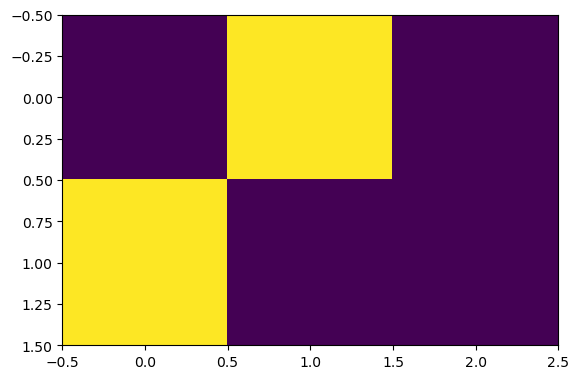

In [5]:
M_example = np.array([[0, 1, 0], [1, 0, 0]])
plt.imshow(M_example)

Vamos a cambiar la dimensión de nuestra matriz utilizando la función _flatten()_. De esta forma, obtendremos un _array_ con un valor particular para cada pixel.

In [6]:
M_example.flatten()

array([0, 1, 0, 1, 0, 0])

Para nuestro ejemplo, se intentará clasificar los números 1 y 2 particularmente. Puede quedar como ejercicio para el estudiante replicar con los números del 0 al 9. 
Se creó una serie de imágenes con ejemplos de trazos que contienen al uno y al dos. Veremos un ejemplo de estos:

In [7]:
folder = 'numbers' # Carpeta que contiene mis dibujos.
img = cv2.imread(f'{folder}/1_17.jpg')

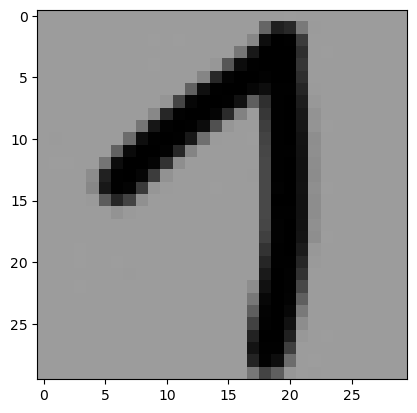

In [8]:
plt.imshow(img)
plt.show()

¿Saben qué es Data Augmentation? Pues haremos uso de esta técnica para no tener que replicar tantos dibujos. Un ejemplo de esto es realizar una pequeña rotación que permite obtener datos adicionales mediante transformación.

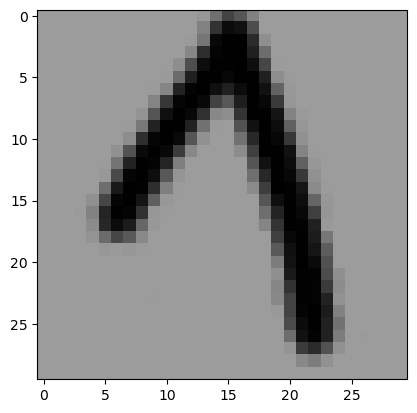

In [9]:
angle = 30
angle = int(random.uniform(-angle, angle))
if angle < 10:
    angles = 30
h, w = img.shape[:2]
M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
img2 = cv2.warpAffine(img, M, (w, h), borderValue=(156,156,156))
plt.imshow(img2)
plt.show()

Pero lo anterior solo lo hemos hecho para una imagen particular, ahora replicaremos utilizando todo nuestro dataset.

In [10]:
M = []
y = []
for root, dirs, files in os.walk(folder, topdown=False):
    for name in files:
        # Agregamos imágenes originales
        path = os.path.join(root, name)
        matrix = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        y.append(path.split('/')[1].split('_')[0])
        M.append(matrix)
        # Agregamos imágenes rotadas
        angle = 30
        angle = int(random.uniform(-angle, angle))
        if angle < 10:
            angles = 10
        h, w = matrix.shape[:2]
        M_rot = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
        matrix2 = cv2.warpAffine(matrix, M_rot, (w, h), borderValue=(156,156,156))
        y.append(path.split('/')[1].split('_')[0])
        M.append(matrix2)

Ahora vamos a visualizar algunos ejemplos:

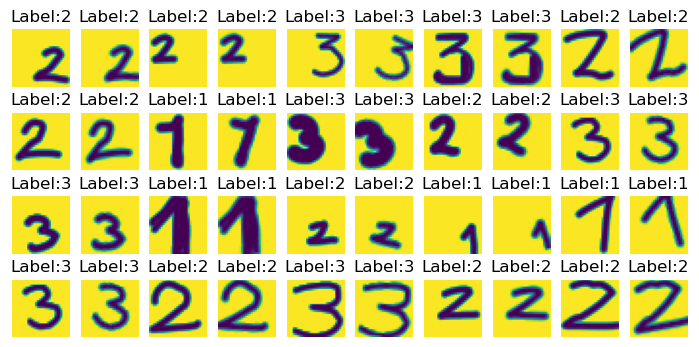

In [11]:
h, w = 4, 10
fig = plt.figure(figsize=(w, h))
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
for i in range(w*h):
    fig.add_subplot(h, w, i + 1).set_title(f'Label:{y[i]}')
    ax = plt.imshow(M[i])    
    plt.axis('off')
plt.show()

Hasta ahora todo maravilloso, pero no hemos hecho nada de Random forest, ¿cómo lo hacemos?
Primero, necesitamos entregarle un vector, por ende, haremos uso de nuestra función _flatten()_ para capturar cada uno de los pixeles por sí solos en una lista.

In [12]:
X = []
for i in range(len(M)):
    X.append(M[i].flatten())

¡Ahora sí! Tenemos todo listo para empezar a entrenar nuestro modelo. Pero primero, necesitamos separar en set de entrenamiento y de validación.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Ahora se procede a entrenar nuestro modelo.

In [20]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators = 500)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500)

Dado que nuestras imágenes son pequeñas y el dataset también lo es, no se tarda mucho en procesar, sin embargo, *Random Forest* acostumbra a ser un modelo poco eficiente para este tipo de clasificación. Ahora vamos a predecir con nuestro set de validación.

In [21]:
y_pred = clf.predict(X_test)

In [22]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)

In [23]:
print(report)

              precision    recall  f1-score   support

           1       1.00      0.83      0.91         6
           2       1.00      0.89      0.94         9
           3       0.83      1.00      0.91        10

    accuracy                           0.92        25
   macro avg       0.94      0.91      0.92        25
weighted avg       0.93      0.92      0.92        25



Se obtiene un accuracy cercano al 100%. En nuestro caso, las clases están balanceadas, pero hay que tener cuidado con mirar solo esta métrica para comparar modelos.
En general, los resultados no están tan mal, ¿podríamos intentar engañar a nuestro modelo?

In [24]:
M_real = []
y_real = []
test_folder = 'test'
for root, dirs, files in os.walk(test_folder, topdown=False):
    for name in files:
        path = os.path.join(root, name)
        matrix = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        y_real.append(path.split('/')[1].split('_')[0])
        M_real.append(matrix)
print(y_real)

['7', '2', '1', '1', '2', '5', '1', '2']


Recordamos utilizar un array en una dimensión.

In [25]:
X_real = []
for i in range(len(M_real)):
    X_real.append(M_real[i].flatten())
y_pred = clf.predict(X_real)


Y ahora podemos revisar qué clasificó nuestro modelo.

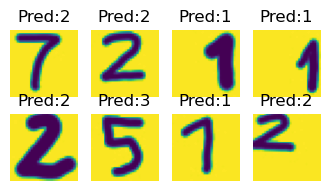

In [26]:
h, w = 2, 4
fig = plt.figure(figsize=(w, h))

for i in range(w*h):
    fig.add_subplot(h, w, i + 1).set_title(f'Pred:{y_pred[i]}')
    ax = plt.imshow(M_real[i])    
    plt.axis('off')
plt.show()

Otro ejemplo para Naive Bayes y Análisis discriminante. 

In [27]:
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis,
                                           QuadraticDiscriminantAnalysis)

clf_NB = GaussianNB()
clf_LD = LinearDiscriminantAnalysis()
clf_QD = QuadraticDiscriminantAnalysis()

En este caso nos centraremos en un dataset que permite entrenar modelos con la finalidad de predecir tumores malignos.

In [28]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()

In [29]:
list(data.target_names)

['malignant', 'benign']

In [30]:
data.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [31]:
df = pd.DataFrame(data.data, columns=data.feature_names)
target = pd.DataFrame(data.target).rename(columns={0:'Diagnosis'})
df = pd.concat([df, target], axis=1)
df.head()


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,Diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


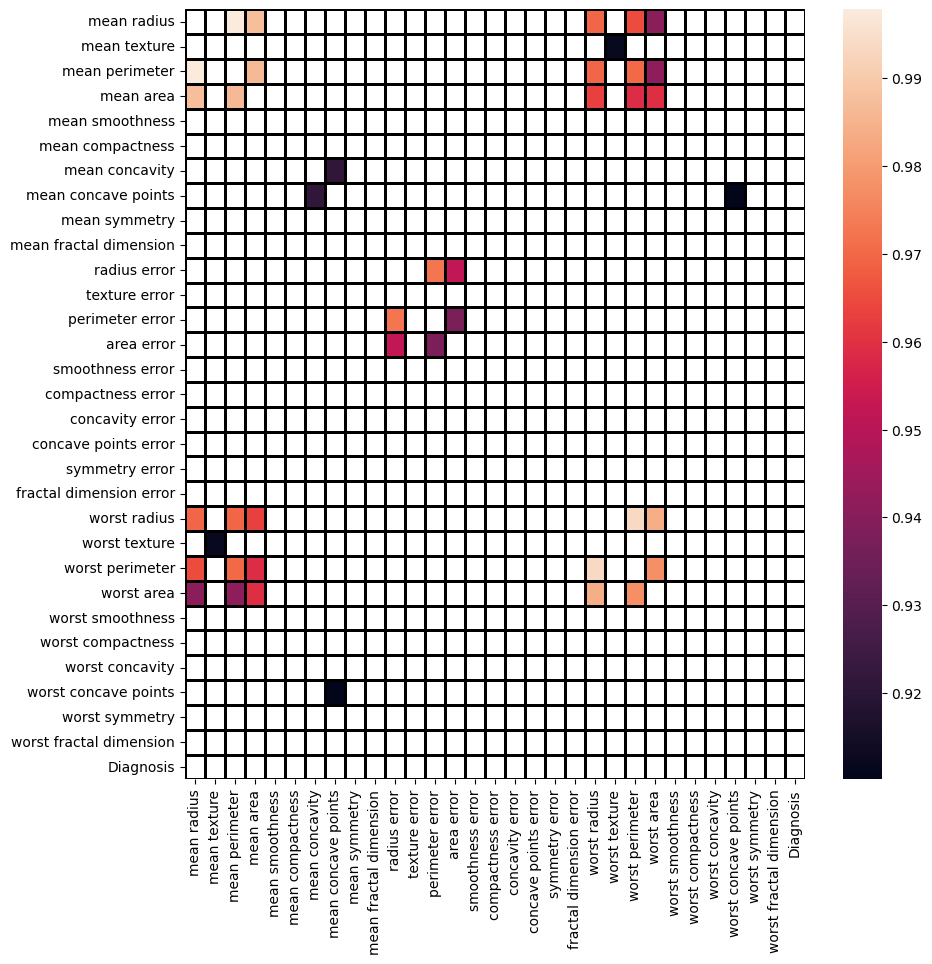

In [32]:
import seaborn as sns

corr = df.corr()
plt.figure(figsize=(10,10));
sns.heatmap(corr[(corr>0.9) & (corr != 1.0)], linewidths=1, linecolor='black');

Sería interesante realizar una reducción de dimensionalidad empaquetando las variables altamente correlacionadas. Sin embargo, para efectos de este tutorial, simplemente usaremos todas las variables.

In [33]:
X, y = load_breast_cancer(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [34]:
clf_NB.fit(X_train, y_train)
clf_LD.fit(X_train, y_train)
clf_QD.fit(X_train, y_train)

QuadraticDiscriminantAnalysis()

In [35]:
y_pred_NB = clf_NB.predict(X_test)

In [36]:
report = classification_report(y_test, y_pred_NB)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.91      0.91        47
           1       0.94      0.94      0.94        67

    accuracy                           0.93       114
   macro avg       0.93      0.93      0.93       114
weighted avg       0.93      0.93      0.93       114



In [37]:
y_pred_LD = clf_LD.predict(X_test)
report = classification_report(y_test, y_pred_LD)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.91      0.96        47
           1       0.94      1.00      0.97        67

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



In [38]:
y_pred_QD = clf_QD.predict(X_test)
report = classification_report(y_test, y_pred_QD)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.96      0.95        47
           1       0.97      0.96      0.96        67

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114

